# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add TSE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TSE2D")

Wall time: 0 ns


# Overview

In the following notebok we evaluate the Trajectory-Stretching-Exponents $ (\mathrm{TSE}, \mathrm{\overline{TSE}}) $ on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data
 <br />
5. Trajectory Stretching Exponent $ \mathrm{TSE} $ and averaged Trajectory Stretching Exponent $ \mathrm{\overline{TSE}} $ :
    
    * Compute velocity along trajectories $ \lbrace \mathbf{\dot{x}}(t_{i}) \rbrace_{i=0}^N $ over the time interval $ [t_0, t_N] $.
     <br />
     
    * Compute $ \mathrm{TSE} $ from velocity along trajectories:
    
    \begin{equation}
        \mathrm{TSE}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \log{\dfrac{\sqrt{|\mathbf{\dot{x}}(t_N)|^2 +\mathrm{v}_0^2}}{\sqrt{|\mathbf{\dot{x}}(t_0)|^2 +\mathrm{v}_0^2}}}
    \end{equation}
     <br />
     
    * Compute $ \mathrm{\overline{TSE}} $ from velocity along trajectories:
    
    \begin{equation}
        \mathrm{\overline{TSE}}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \sum_{i=0}^{N-1}|\log{\dfrac{\sqrt{|\mathbf{\dot{x}}(t_{i+1})|^2 +\mathrm{v}_0^2}}{\sqrt{|\mathbf{\dot{x}}(t_i)|^2 +\mathrm{v}_0^2}}}|
    \end{equation}
     <br />
     
    $ \mathrm{v}_0 $ is a characteristic velocity, which can be estimated by taking the spatio-temporal average of the velocity over the whole dataset.

# Import Data

In [2]:
%%time
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u'] # array (NY, NX, NT)
V = mat_file['v'] # array (NY, NX, NT)
x = mat_file['x'] # array (NY, NX)
y = mat_file['y'] # array (NY, NX)
time_data = mat_file['t'] # array (1, NT)

Wall time: 173 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
%%time
import numpy as np

# Number of cores for parallel computing
Ncores = 6 # int

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0] # float

# Periodic boundary conditions
periodic_x = False # bool
periodic_y = False # bool
periodic_t = False # bool
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int) # array (NY, NX)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y) # array (NY, NX), array (NY, NX)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0] # float
dy_data = Y[1,0]-Y[0,0] # float

delta = [dx_data, dy_data] # list (2, )

Wall time: 0 ns


# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 25 # float

# Time step-size (in days)
dt = .1 # float

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# Longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5 # float
xmax = 1 # float
ymin = -32 # float
ymax = -24 # float

# Make sure that the chosen domain is part of the data domain
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# Spacing of meshgrid (in degrees)
dx = 0.025 # float
dy = 0.025 # float

x_domain = np.arange(xmin, xmax + dx, dx) # array (Nx, )
y_domain = np.arange(ymin, ymax + dy, dy) # array (Ny, )

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int

Wall time: 997 µs


# Velocity interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object

Wall time: 296 ms


# Trajectory Stretching Exponents

Next we compute the $ \mathrm{TSE} $ and $ \mathrm{\overline{TSE}} $ by first computing the velocity along the particle trajectories.

In [6]:
%%time
# Import function to compute trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to check location of particle
from ipynb.fs.defs.check_location import check_location

# Import package for parallel computing
from joblib import Parallel, delayed

# Import function to compute TSE/TSE_bar
from ipynb.fs.defs.TSE import _TSE, _TSE_bar

# Set v0 equal to the average velocity in the Agulhas region. This was estimated in [1]
v0 = 0.2 # float

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

def parallel_TSE(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])  # array (2, Nx*Ny)
    
    # Compute velocity along trajectories
    dFdt = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[1] # shape (Nt-1, 2, Nx*Ny)

    # Initialize arrays storing TSE diagnostics
    TSE_parallel = x0_batch.copy()*np.nan # array (Nx*Ny, )
    TSE_bar_parallel = x0_batch.copy()*np.nan # array (Nx*Ny, )
    
    for j in range(X0.shape[1]):
        
        # Set initial condition
        x = X0[:,j]  # array (2, )
        
        # Only compute TSE for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":

            TSE_parallel[j] = _TSE(lenT, dFdt[:,:,j], v0)
            TSE_bar_parallel[j] = _TSE_bar(lenT, dFdt[:,:,j], v0)
        
    return TSE_parallel, TSE_bar_parallel

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_TSE)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract TSE/TSE_bar from results of parallel computing
TSE = results[0][0]
TSE_bar = results[0][1]

for i in range(1,len(results)):
    TSE = np.append(TSE, results[i][0])
    TSE_bar = np.append(TSE_bar, results[i][1])

# Reshape array from vectorized form to structured meshgrid for plotting purposes
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)
TSE = TSE.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)
TSE_bar = TSE_bar.reshape((X_domain.shape[0], X_domain.shape[1])) # (Ny, Nx)

Wall time: 1min 11s


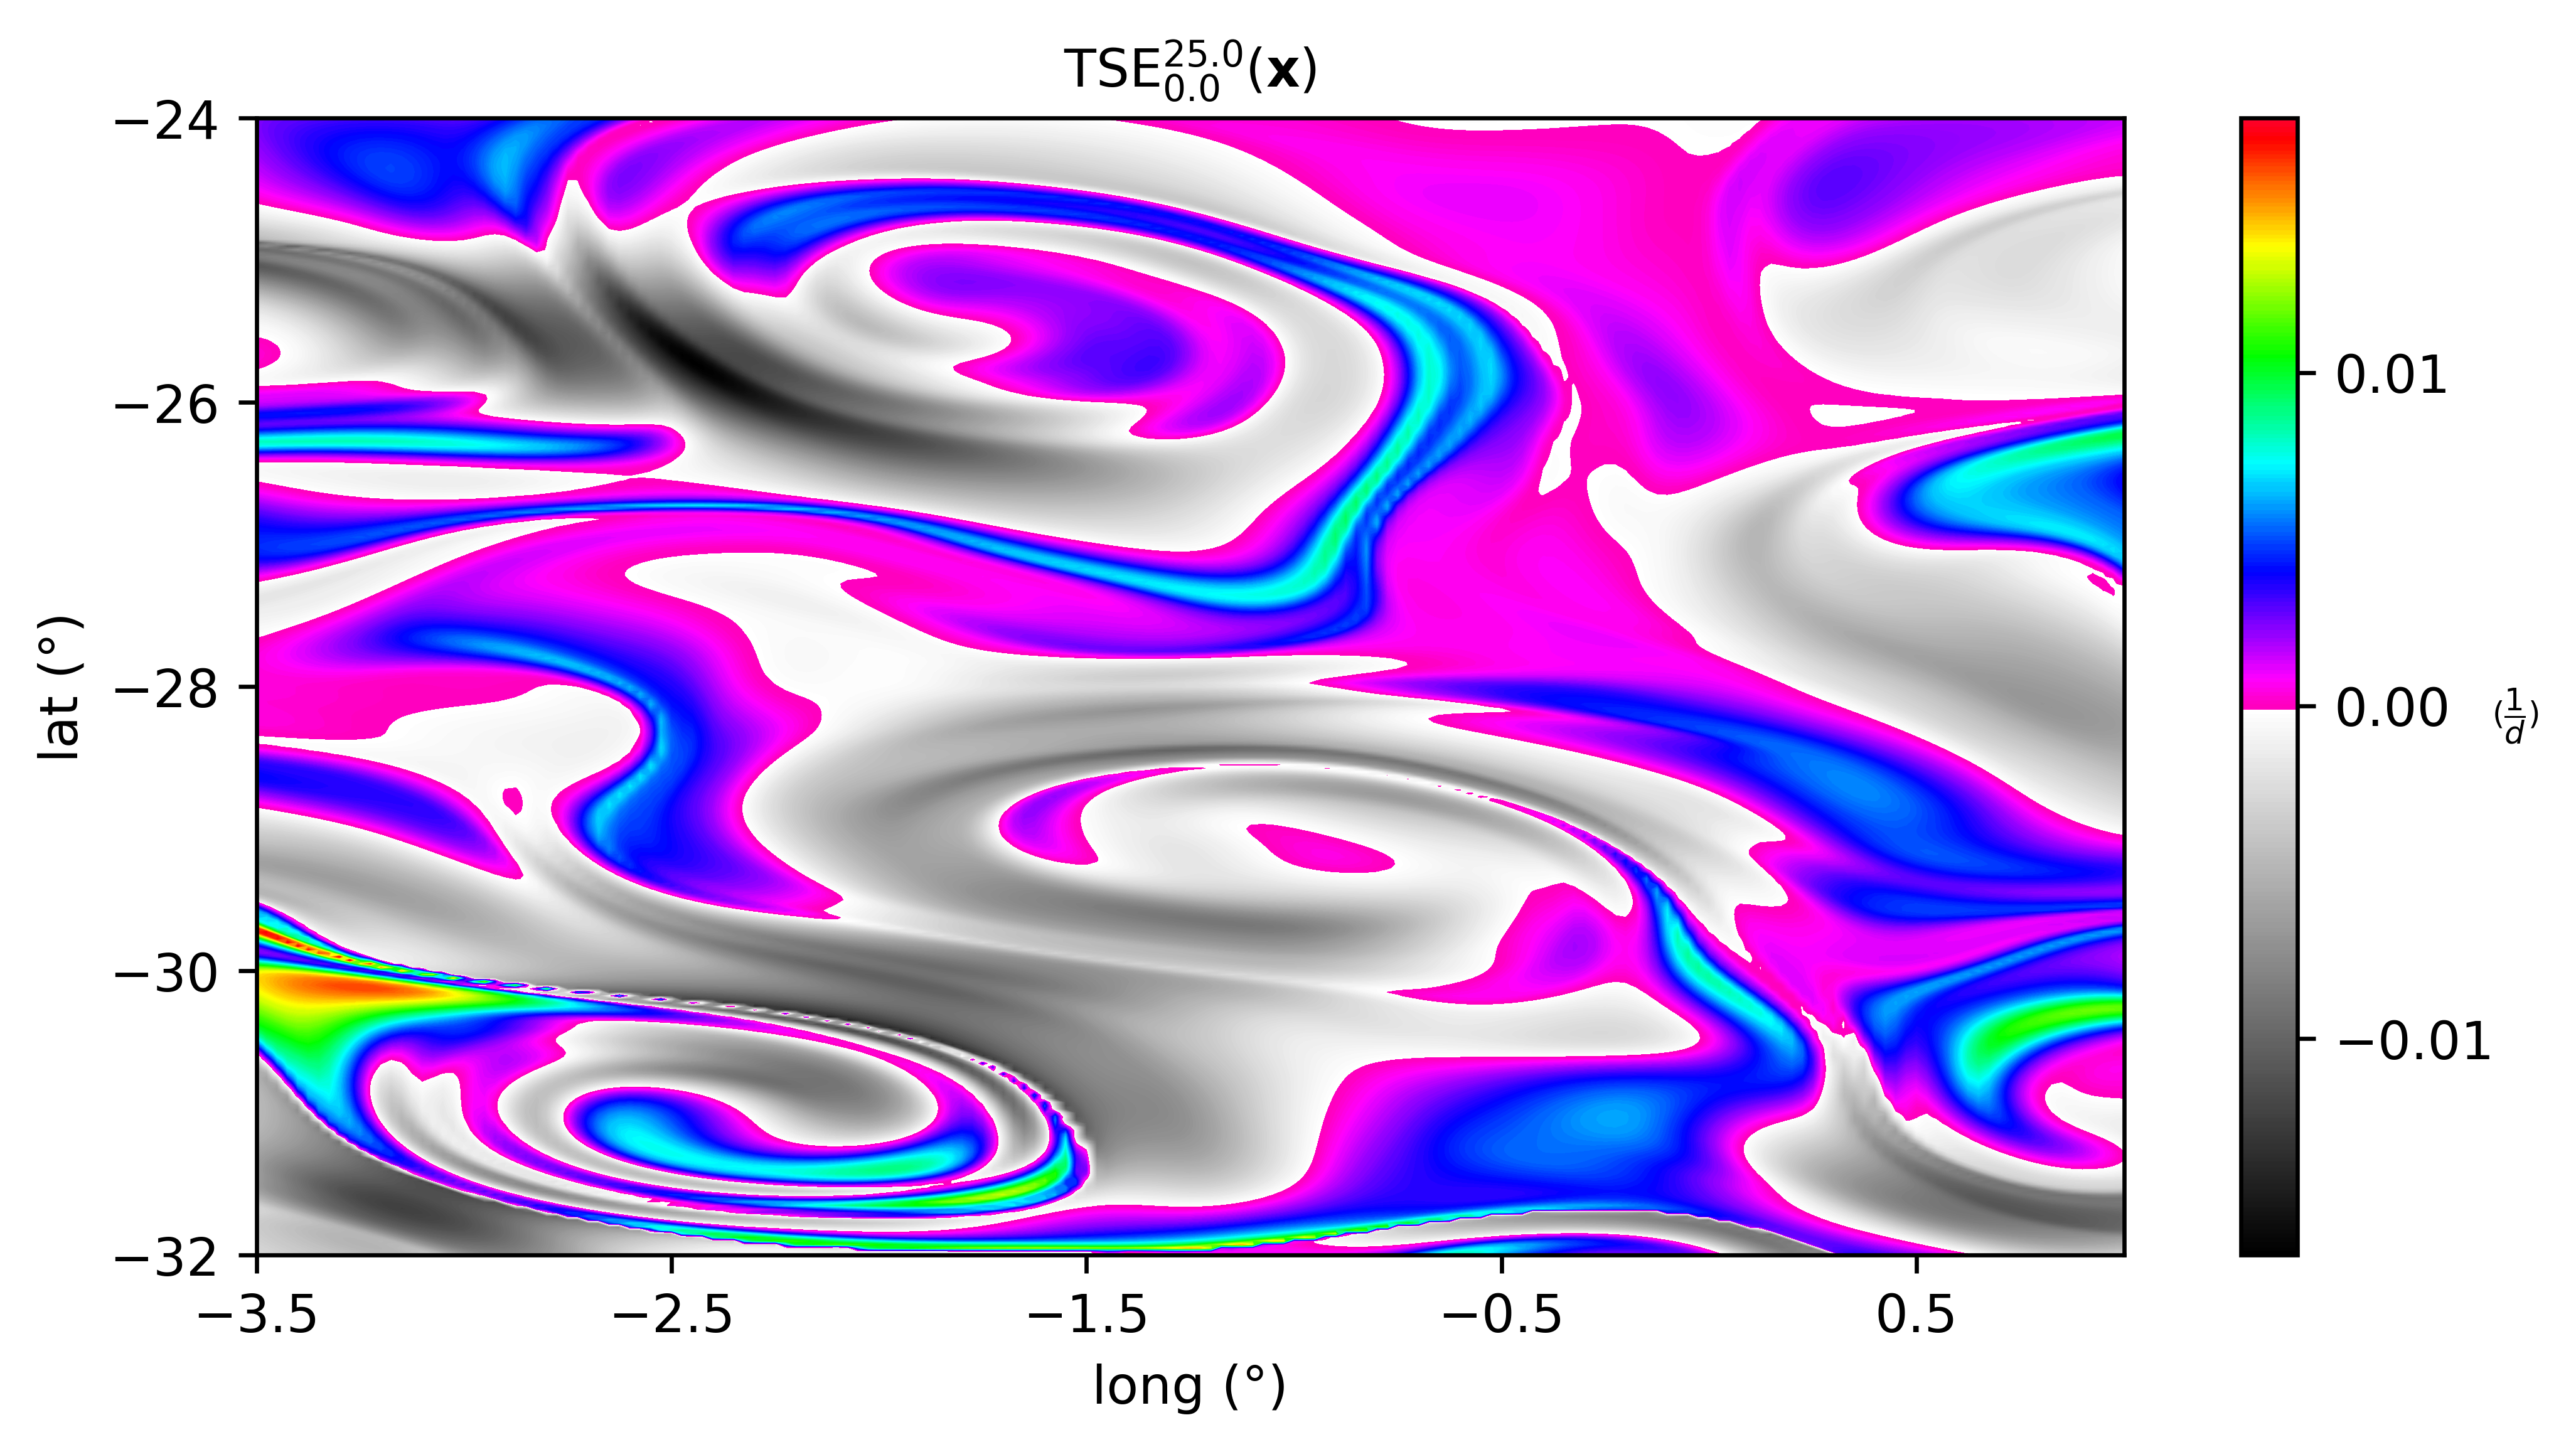

In [7]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Sample the colormaps that you want to use. Use 128 from each so we get 256 colors in total

split_colors = int(256*abs(np.nanmin(TSE))/(np.nanmax(TSE)-np.nanmin(TSE)))
colors1 = plt.cm.binary_r(np.linspace(0, 1, split_colors))
colors2 = plt.cm.gist_rainbow_r(np.linspace(0, 1, 256-split_colors))

# Combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(TSE), cmap = mymap, levels = 600)

cax.cmap.set_under('w')

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.1, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.1, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(-0.04, 0.04, 9))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, fontsize = 6)

ax.set_title(r'$\mathrm{TSE}$' + f'$_{{{np.around(time[0],2)}}}^{{{np.around(time[-1],2)}}}$'+'$(\mathbf{x})$', fontsize = 10)

plt.show()

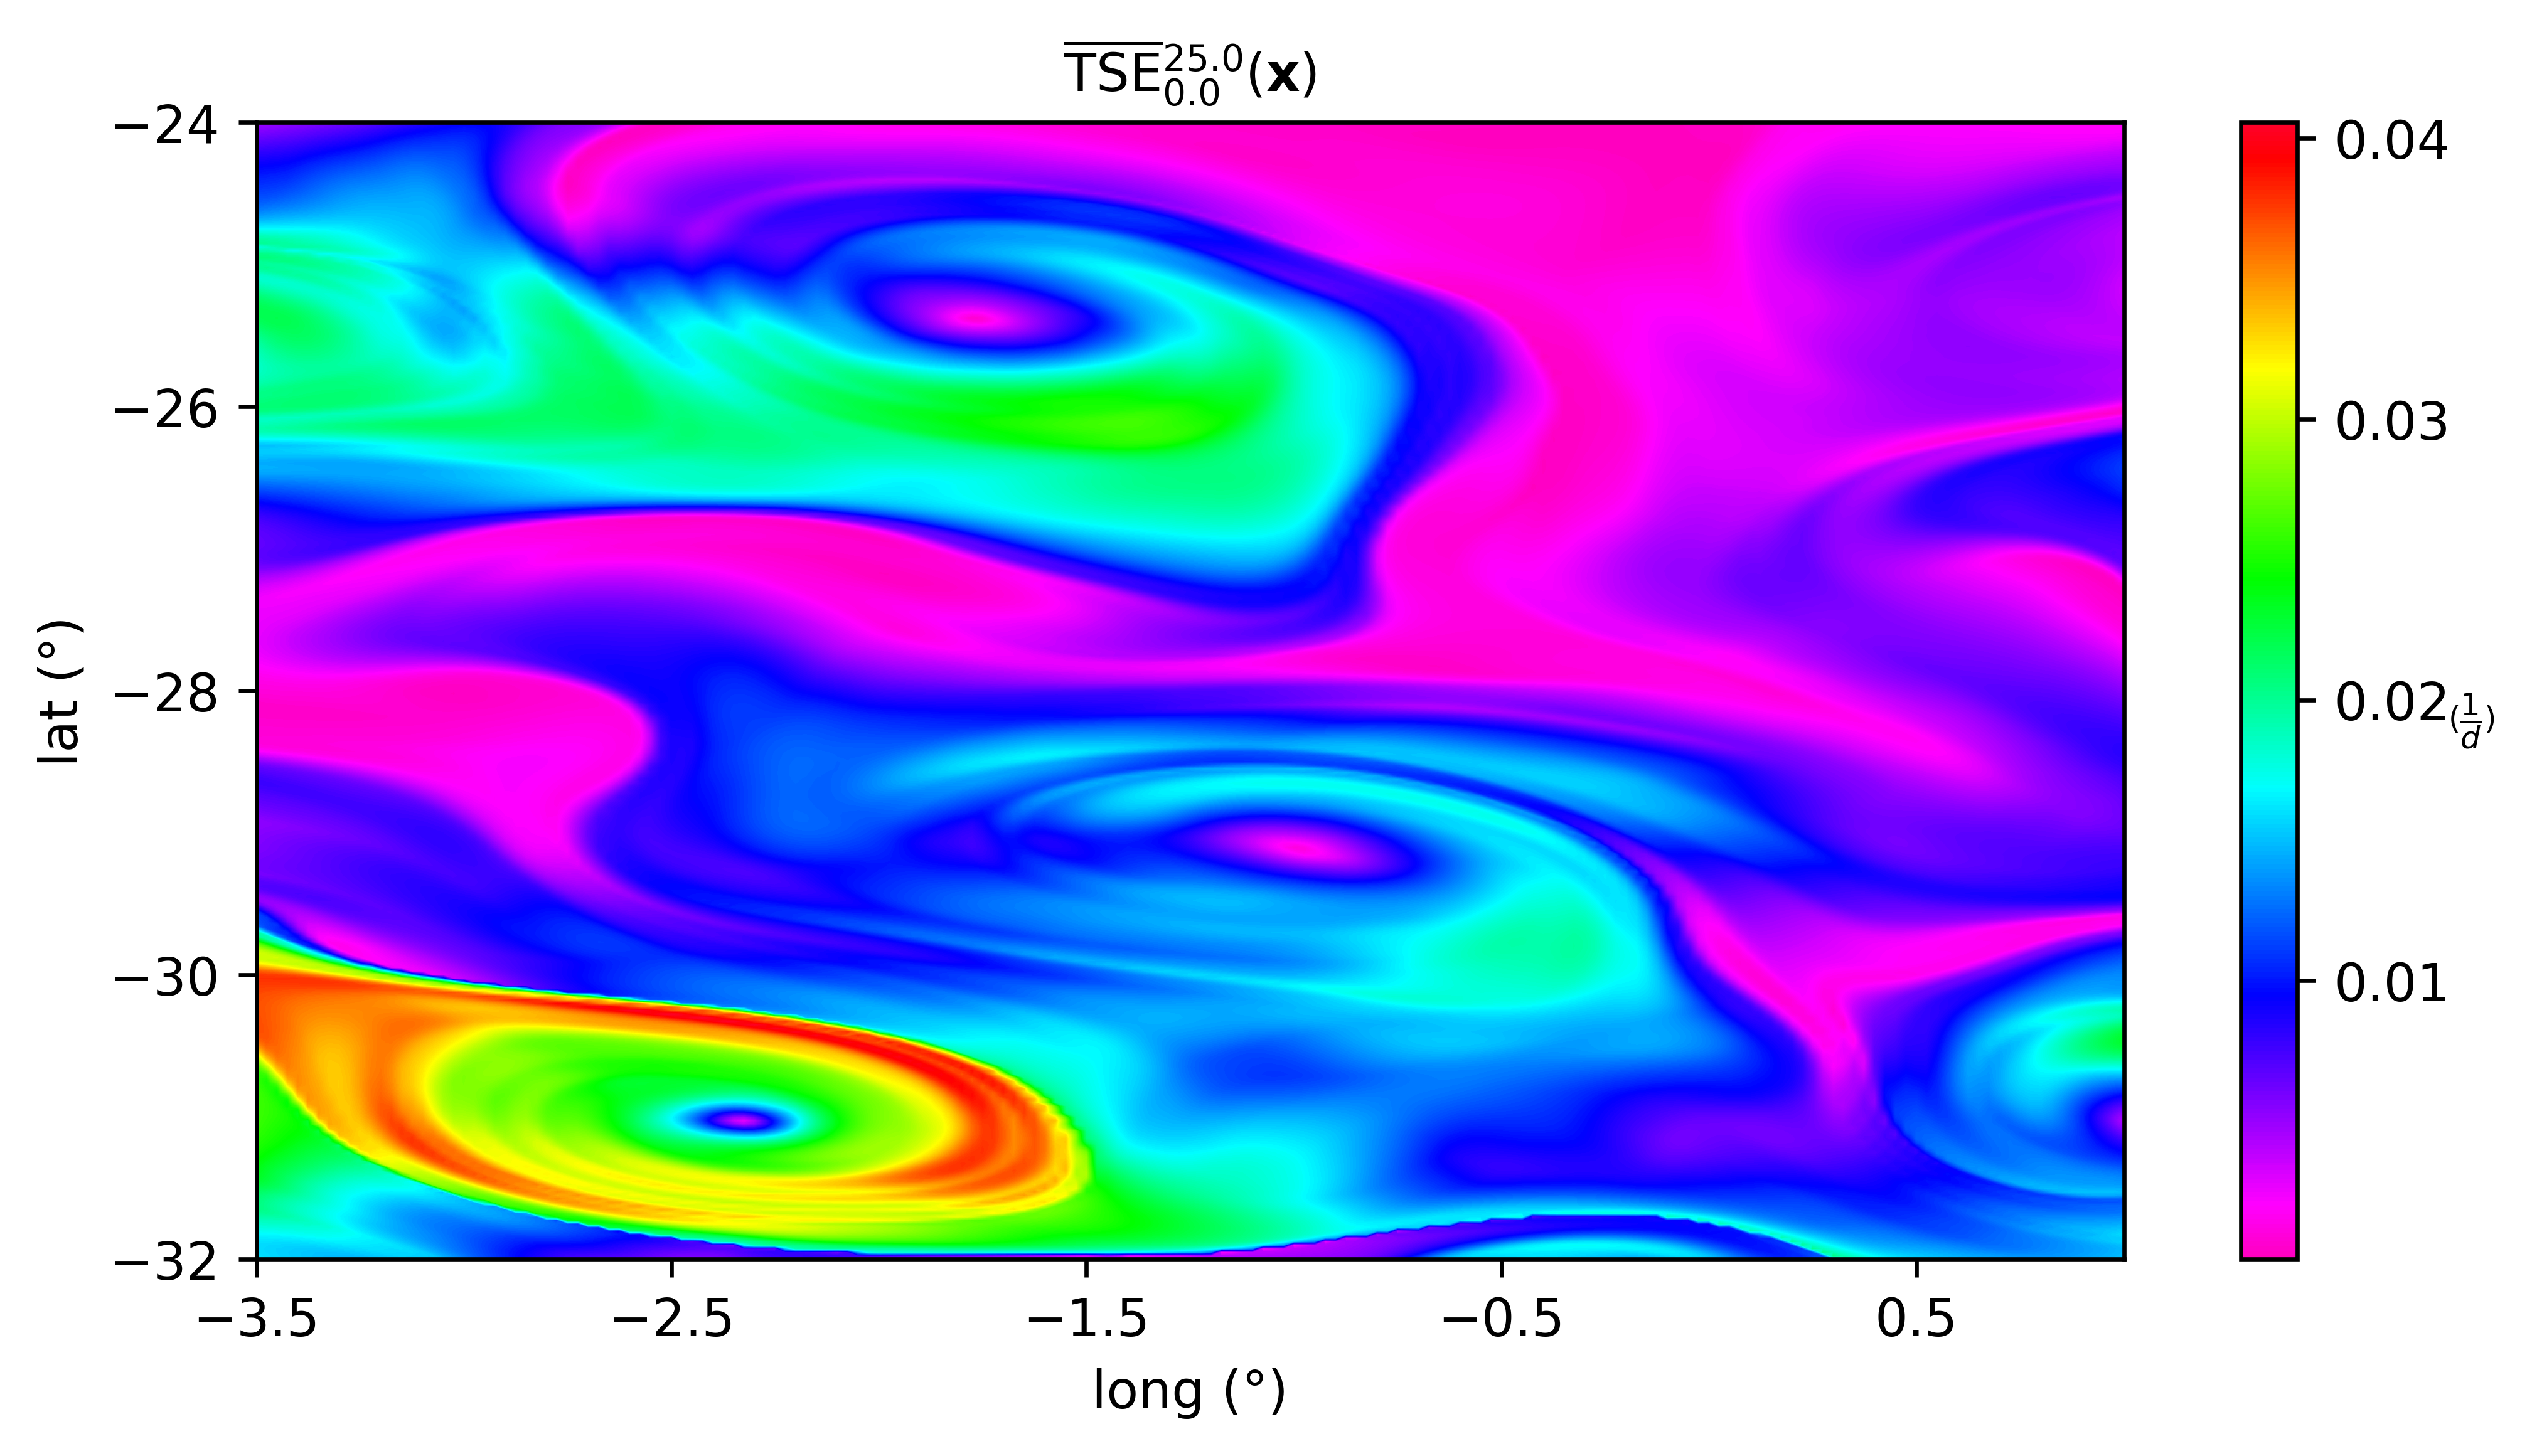

In [8]:
######################## PLOT RESULTS ########################
import matplotlib.colors as colors

# Figure/Axis
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(TSE_bar), levels = 600, cmap = "gist_rainbow_r")

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.1, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.2, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(0, 0.05, 0.01))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, fontsize = 6)

ax.set_title(r'$\mathrm{\overline{TSE}}$' + f'$_{{{np.around(time[0],2)}}}^{{{np.around(time[-1],2)}}}$'+'$(\mathbf{x})$', fontsize = 10)

plt.show()

The $ \mathrm{\overline{TSE}}_{t_0}^{t_N} $ and the $ \mathrm{TSE}_{t_0}^{t_N} $ are single trajectory indicators for hyperbolic LCS. The ridges of $ \mathrm{TSE}_{t_0}^{t_N} $ approximate the major ridges of the FTLE field (see [FTLE](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/FTLE/Main/FTLEAgulhas.ipynb)) at a much lower computational cost as there is no need to compute the spatial derivatives involved when evaluating the FTLE-field.

# References

[1] Haller, G., Aksamit, N., & Encinas-Bartos, A. P. (2021). Quasi-objective coherent structure diagnostics from single trajectories. Chaos: An Interdisciplinary Journal of Nonlinear Science, 31(4), 043131.

[2] Notebook 5.5.1 in "Transport Barriers and Coherent Structures in Flow Data" by George Haller